Shape of dataset: (5215, 7)

Columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']

First 5 rows:
          date       open       high        low      close  adj_close    volume
0  2004-11-18  44.380001  44.380001  44.490002  44.070000  44.430000   5992000
1  2004-11-19  44.779999  44.779999  44.919998  44.470001  44.490002  11655300
2  2004-11-22  44.950001  44.950001  44.970001  44.740002  44.750000  11996000
3  2004-11-23  44.750000  44.750000  44.919998  44.720001  44.880001   3169200
4  2004-11-24  45.049999  45.049999  45.049999  44.790001  44.930000   6105100

Missing values:
 date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
Duplicate rows: 0

Descriptive Statistics:
                                 date         open         high          low  \
count                           5215  5215.000000  5215.000000  5215.000000   
mean   2015-03-30 04:17:37.564717056   131.940968   131.940968   132.5

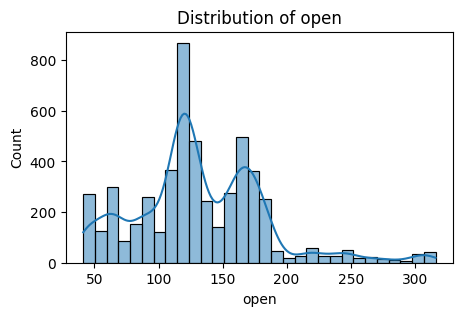

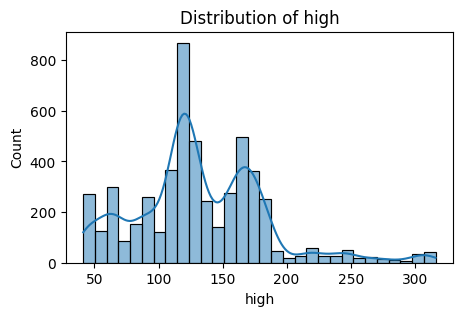

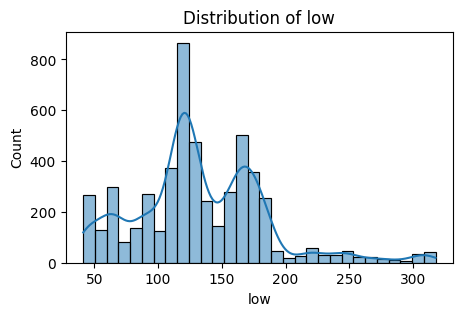

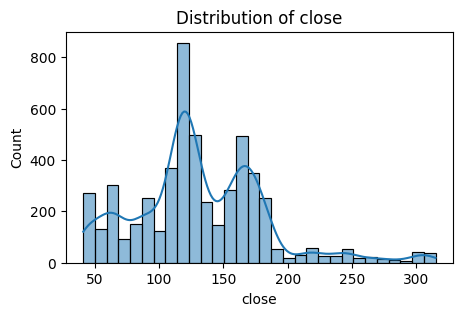

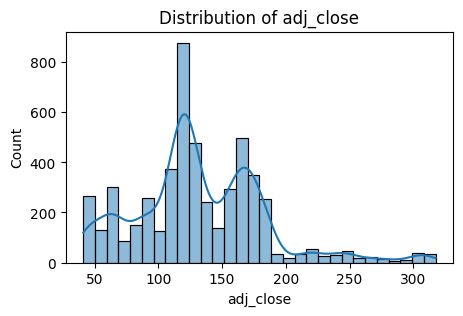

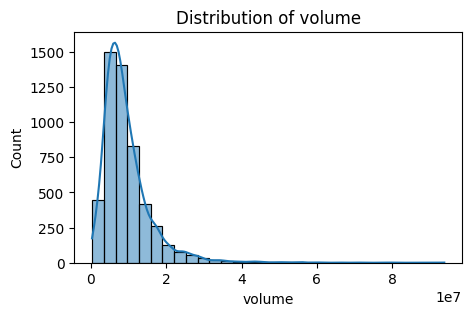

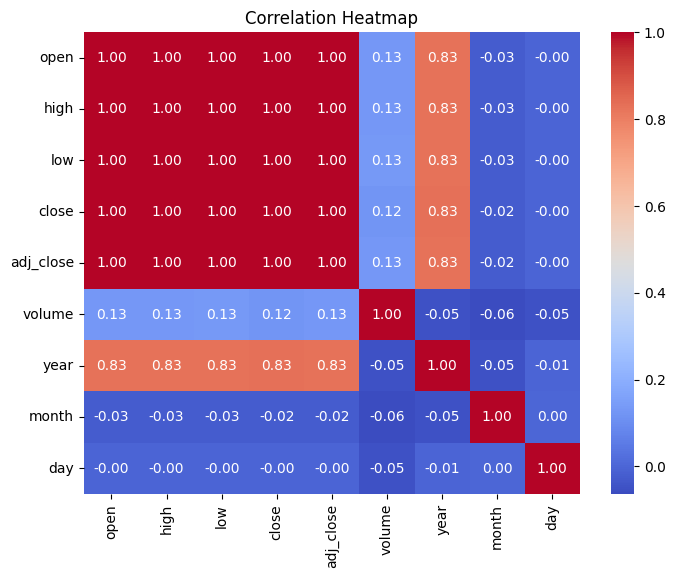


Selected Features (X): ['open', 'high', 'low', 'adj_close', 'volume', 'year', 'month', 'day']
Target Variable (y): close

Training set: (4172, 8) Testing set: (1043, 8)

Model Evaluation:
MSE: 0.1320496324063136
RMSE: 0.36338634042340334
R² Score: 0.9999505103152225


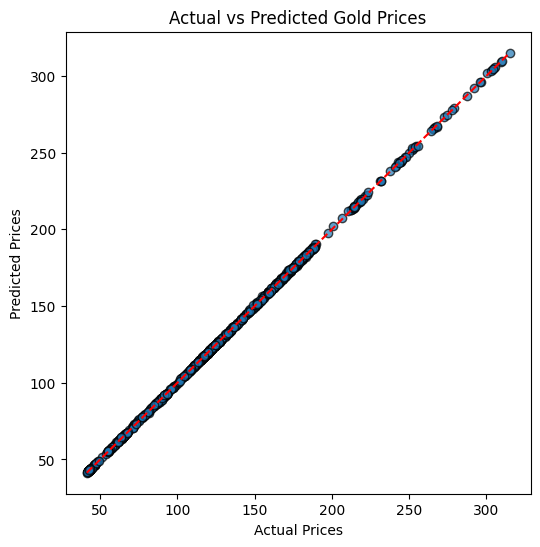


Feature Importance (Impact on Gold Price):
      Feature   Coefficient
3  adj_close  6.217508e-01
0       open  3.614915e-01
1       high  3.614915e-01
5       year  1.531989e-02
6      month  1.523454e-03
7        day  9.229408e-05
4     volume -2.677323e-08
2        low -3.488147e-01


In [20]:
# 1. Load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load CSV
df = pd.read_csv("gold_price_data.csv")

# Display shape, columns, first 5 rows
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())

# 2. Missing values & duplicates
print("\nMissing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

# Convert 'date' to datetime if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    # Extract useful time features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day

# Fill missing values (numeric → median, categorical → mode)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# 3. Exploratory Data Analysis (EDA)
print("\nDescriptive Statistics:\n", df.describe())

# Plot distributions for first 6 numeric features
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols[:6]:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# 4. Correlation Heatmap (numeric only)
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 5. Select Features (X) and Target (y)
# Set target column: use "close" or "adj_close"
target_col = "close"   # <-- change to "adj_close" if preferred

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available: {df.columns.tolist()}")

# Independent variables = all numeric except target
features = [col for col in num_cols if col != target_col]

X = df[features]
y = df[target_col]

print("\nSelected Features (X):", features)
print("Target Variable (y):", target_col)

# 6. Train-Test Split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining set:", X_train.shape, "Testing set:", X_test.shape)

# 7. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Evaluate the Model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)

# 9. Plot Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Gold Prices")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.show()

# 10. Interpret Coefficients
coeff_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Impact on Gold Price):\n", coeff_df)
